In [66]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as matplotlib
plt.rcParams.update({'font.size': 16})

Text(0, 0.5, 'z(m)')

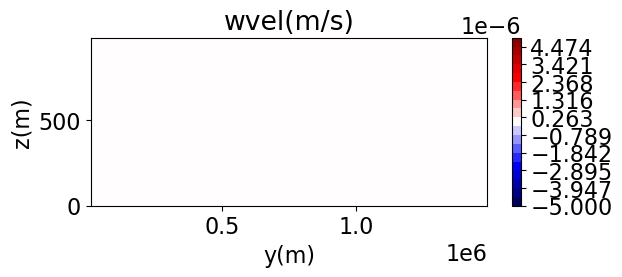

In [77]:
Ny=400 #Number of grids
Nz=50  #Number of grids
Ly=6000000 #in meters
Lz=1000 #in meters
Nk=4 #numbers of "waves" in w
Ly=Ly//Nk
Ny=Ny//Nk
Nk=Nk//Nk
ygrid=np.linspace(0,Ly,Ny)
zgrid=np.linspace(0,Lz,Nz)





basin_width=28000000 #km



ygridt=(ygrid[1:]+ygrid[:-1])/2
zgridt=(zgrid[1:]+zgrid[:-1])/2
ygridu=ygrid[:-1] #v surface,at the negative(south) side of the t grid
zgridu=zgrid[:-1] #w surface,at the negative(top) side of the t grid
dy=ygrid[1]-ygrid[0]
dz=zgrid[1]-zgrid[0]



alpha=1/(Ly)*2*np.pi*Nk #w= Asin(alpha y)
A=1.5e-6*0
wsin=A*np.sin((ygridt)*alpha)
wsin2D=np.tile(wsin,[Nz,1])
#wsin2D[40:,:]=0


v2d=wsin2D.T[:,:-1]*0
w2d=wsin2D.T[:,:-1]*1

# plt.contourf(ygrid,zgrid,wsin2D)
# plt.colorbar()

vgrid=-A/alpha/dz*np.cos(alpha*ygridu)

v2d[:,-1]=vgrid

plt.figure()
plt.subplot(2,1,1)
plt.title('wvel(m/s)')
plt.contourf(ygridt,zgridu,w2d.T,levels=np.linspace(-5,5,20)*1e-6,cmap='seismic')
plt.colorbar()
plt.xlabel('y(m)')
plt.ylabel('z(m)')


Text(0, 0.5, 'z(m)')

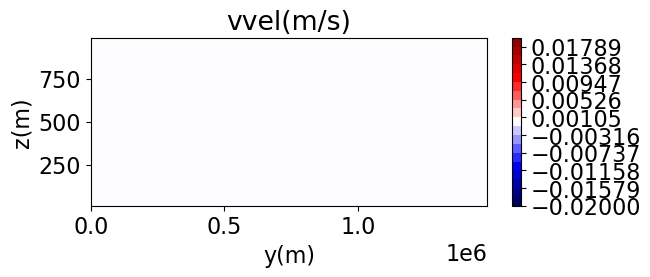

In [78]:

plt.figure()
plt.subplot(2,1,1)


plt.contourf(ygridu,zgridt,v2d.T,levels=np.linspace(-0.02,0.02,20),cmap='seismic')
plt.title('vvel(m/s)')
plt.colorbar()
plt.xlabel('y(m)')
plt.ylabel('z(m)')

# plt.figure()
# plt.plot(np.squeeze(ygridt),np.squeeze(w2d[:,-1])/alpha/dz,'o-')
# plt.plot(np.squeeze(ygridu),np.squeeze(vgrid),'-o')

Text(0, 0.5, 'z(m)')

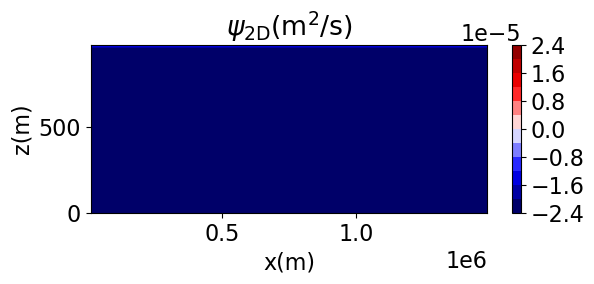

In [79]:
w2dcum=np.cumsum(w2d,axis=0)-2.4*1e-5
w2dcum[:,-1]=0

plt.subplot(2,1,1)
plt.title(r'$\psi_{2\mathrm{D}}$(m$^2$/s)')
plt.contourf(ygridt,zgridu,w2dcum.T,levels=np.linspace(-2.4e-5,2.4e-5,13),cmap='seismic')
plt.colorbar()
plt.xlabel('x(m)')
plt.ylabel('z(m)')


-0.0

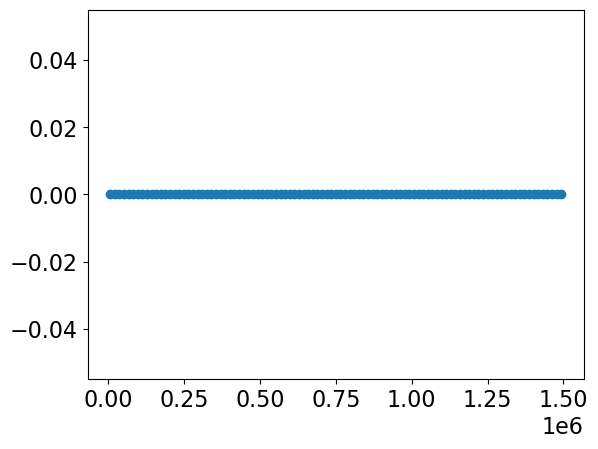

In [80]:
plt.figure()
plt.plot(np.squeeze(ygridt),np.squeeze(w2d[:,-1])/alpha/dz,'o-')
w2d[24,-1]
w2d[74,-1]

In [81]:

Nyt=Ny-1
Nzt=Nz-1
v_basin_grid=v2d
w_basin_grid=w2d

kdia=5e-5
kiso=1000

#dt=86400*10#s
#T=31104000*300#00#31104000*5000 #years->second
dt=8640*2
T=31104000*200
Nt=T//dt
#Nt=40000
kiso=1000#-500#m2/s
#kv=kv0
#kdia=0

tracer=np.zeros([Nyt,Nzt])

#tracer[0,:]=np.linspace(0,400*31104000,Nz)
tracer_source=np.ones([Nyt,Nzt])
tracer_yface=np.zeros([Nyt,Nzt])
tracer_zface=np.zeros([Nyt,Nzt])
grad_y=np.zeros([Nyt,Nzt])
grad_z=np.zeros([Nyt,Nzt])
advy_1=np.zeros([Nyt,Nzt])
advy_2=np.zeros([Nyt,Nzt])
advz_1=np.zeros([Nyt,Nzt])
advz_2=np.zeros([Nyt,Nzt])
##write a 2D solver here

#Age in shear flow
for it in range(0,Nt):
    ##advection: using centered 2nd order scheme
    ##advy is on the negative side of t grid
    ##advy_1: contribution from the negative side of t grid
    advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
    advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
    ##advy_2: contribution from the positive side of t grid
    advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
    advy=advy_1+advy_2
    ##tracer concentration on v grids
    tracer_yface[0,:]=(tracer[-1,:]+tracer[0,:])/2
    tracer_yface[1:,:]=(tracer[0:-1,:]+tracer[1:,:])/2
    advy=tracer_yface*v_basin_grid
    ##advz is on the top side of the t grid
    ##advz_1: contribution from the bottom side of t grid
    advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
    ##advz_2:contribution from the top side of t grid
    advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
    advz=advz_1+advz_2
    tracer_zface[:,1:]=(tracer[:,0:-1]+tracer[:,1:])/2
    advz=tracer_zface*w_basin_grid
    
#     #advection:upwind
#     #advy is on the negative side of t grid
#     #advy_1: contribution from the negative side of t grid
#     advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
#     advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
#     #advy_2: contribution from the positive side of t grid
#     advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
#     advy=advy_1+advy_2
#     #advz is on the top side of the t grid
#     #advz_1: contribution from the bottom side of t grid
#     advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
#     #advz_2:contribution from the top side of t grid
#     advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
#     advz=advz_1+advz_2
    
    grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
    grad_y[0,:]=(tracer[0,:]-tracer[-1,:])/dy
    grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/dz #w grid is on the upper Z surface

    diffy=-kiso*grad_y
    diffz=-kdia*grad_z

    fluxy=advy+diffy 
    fluxz=advz+diffz
    
    tracertop=tracer[:,-1]
    tracertop.shape=(Ny-1,1)
    fluxy=np.vstack((fluxy,fluxy[0,:]))
    fluxz=np.hstack((fluxz,0*tracertop/dz))
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])




Text(0, 0.5, 'z(m)')

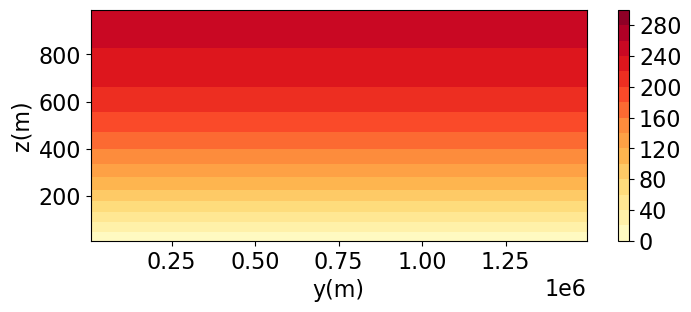

In [82]:
#plot age
age=tracer
age_source=np.ones([Nyt,Nzt])
plt.figure(figsize=(8,3))
plt.contourf(ygridt,zgridt,age.T/31104000,levels=np.linspace(0,300,16),cmap=plt.cm.YlOrRd)
plt.colorbar()
#plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")


#plt.plot(ygridt[yi],zgridt[zi],'o')
plt.xlabel('y(m)')
plt.ylabel('z(m)')

Text(0.5, 1.0, 'Munk balance,KH=1000,Nk=1,Aw=1.5e-06,kdia=[5.00000000e-05 5.68341747e-05 7.24099033e-05 8.54562225e-05\n 9.52418879e-05 1.02031105e-04 1.06509259e-04 1.09374011e-04\n 1.11174850e-04 1.12296265e-04 1.12991324e-04 1.13421261e-04\n 1.13687054e-04 1.13851398e-04 1.13953058e-04 1.14015972e-04\n 1.14054917e-04 1.14079019e-04 1.14093924e-04 1.14103122e-04\n 1.14108779e-04 1.14112236e-04 1.14114327e-04 1.14115572e-04\n 1.14116296e-04 1.14116703e-04 1.14116928e-04 1.14117063e-04\n 1.14117182e-04 1.14117359e-04 1.14117693e-04 1.14118334e-04\n 1.14119536e-04 1.14121744e-04 1.14125750e-04 1.14132989e-04\n 1.14146073e-04 1.14169813e-04 1.14213178e-04 1.14293137e-04\n 1.14442412e-04 1.14725716e-04 1.15275624e-04 1.16378090e-04\n 1.18701565e-04 1.24036411e-04 1.38597086e-04 2.03367626e-04\n 1.00000000e-05],Lz=1000')

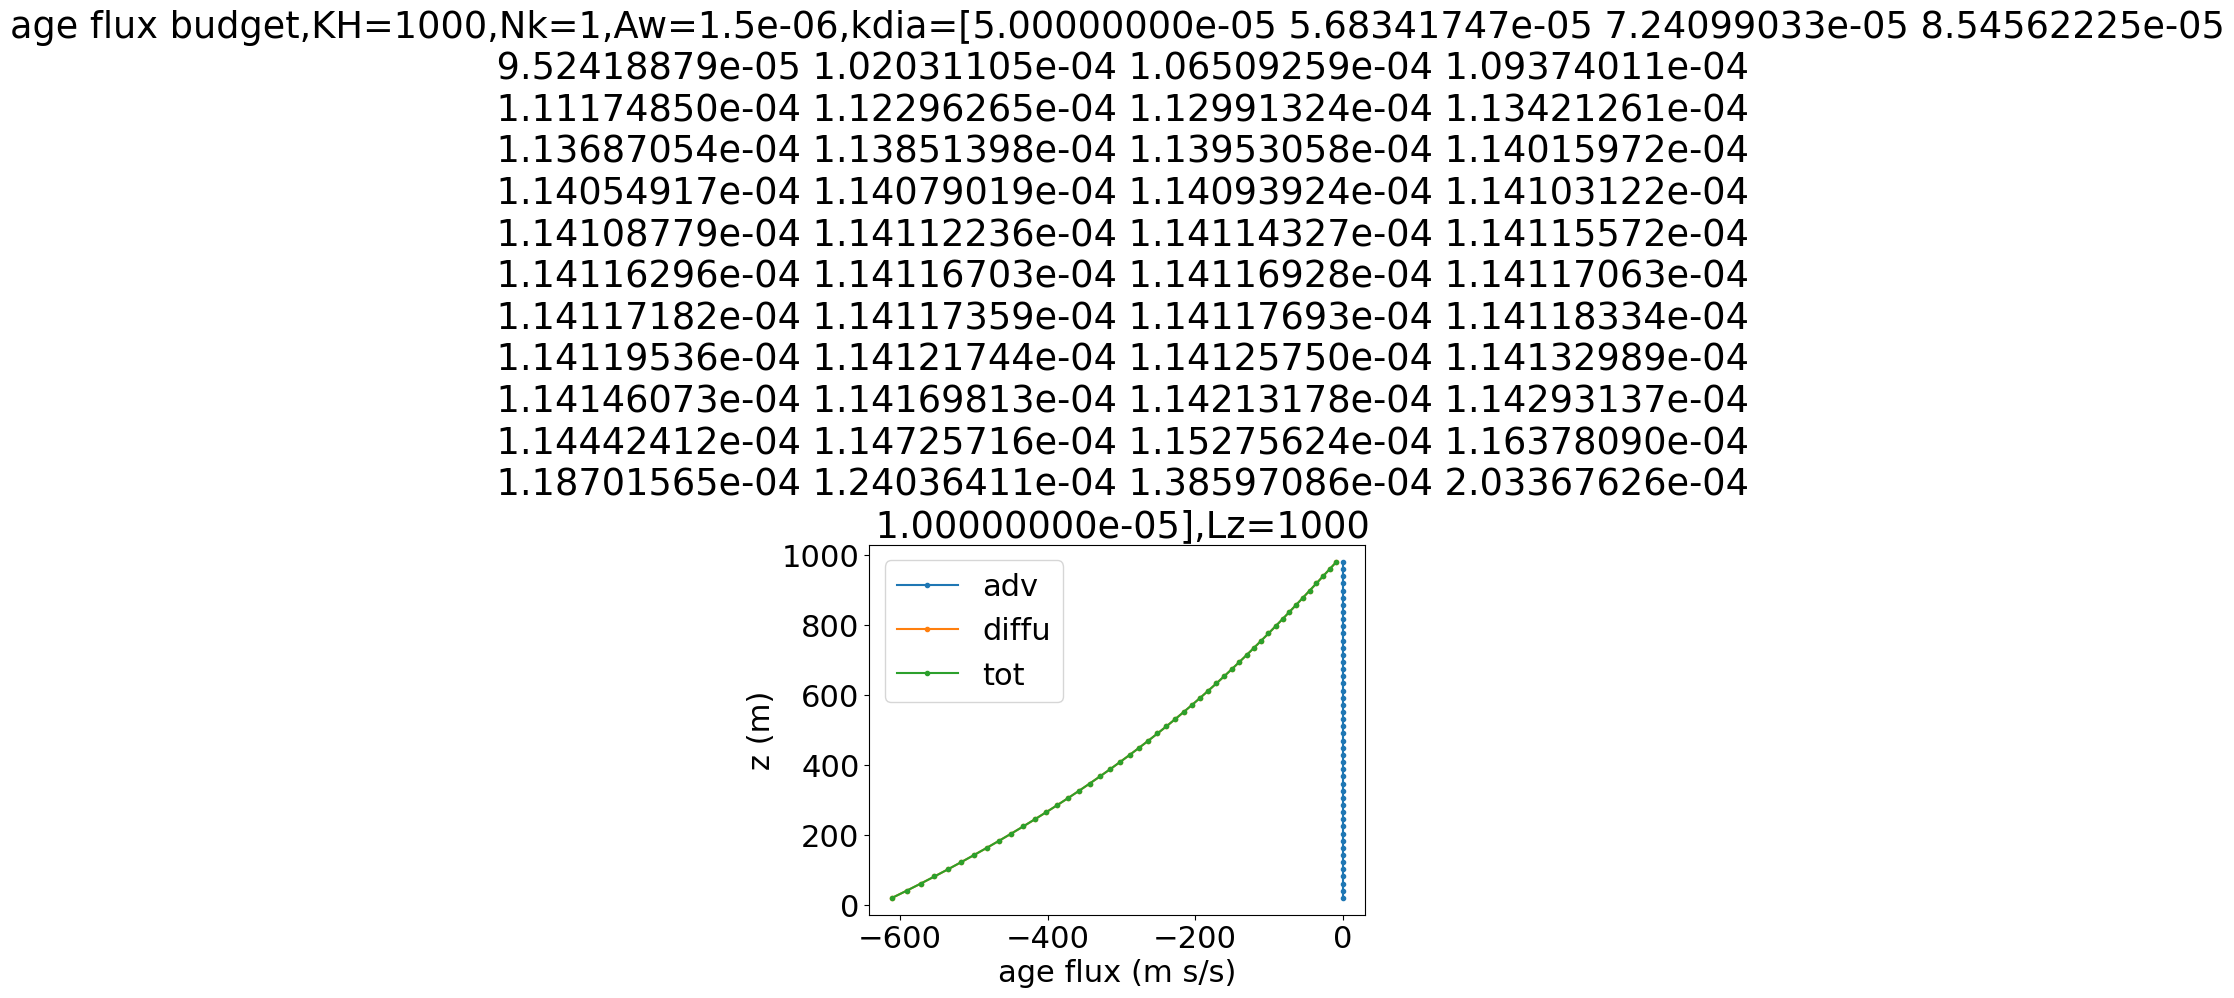

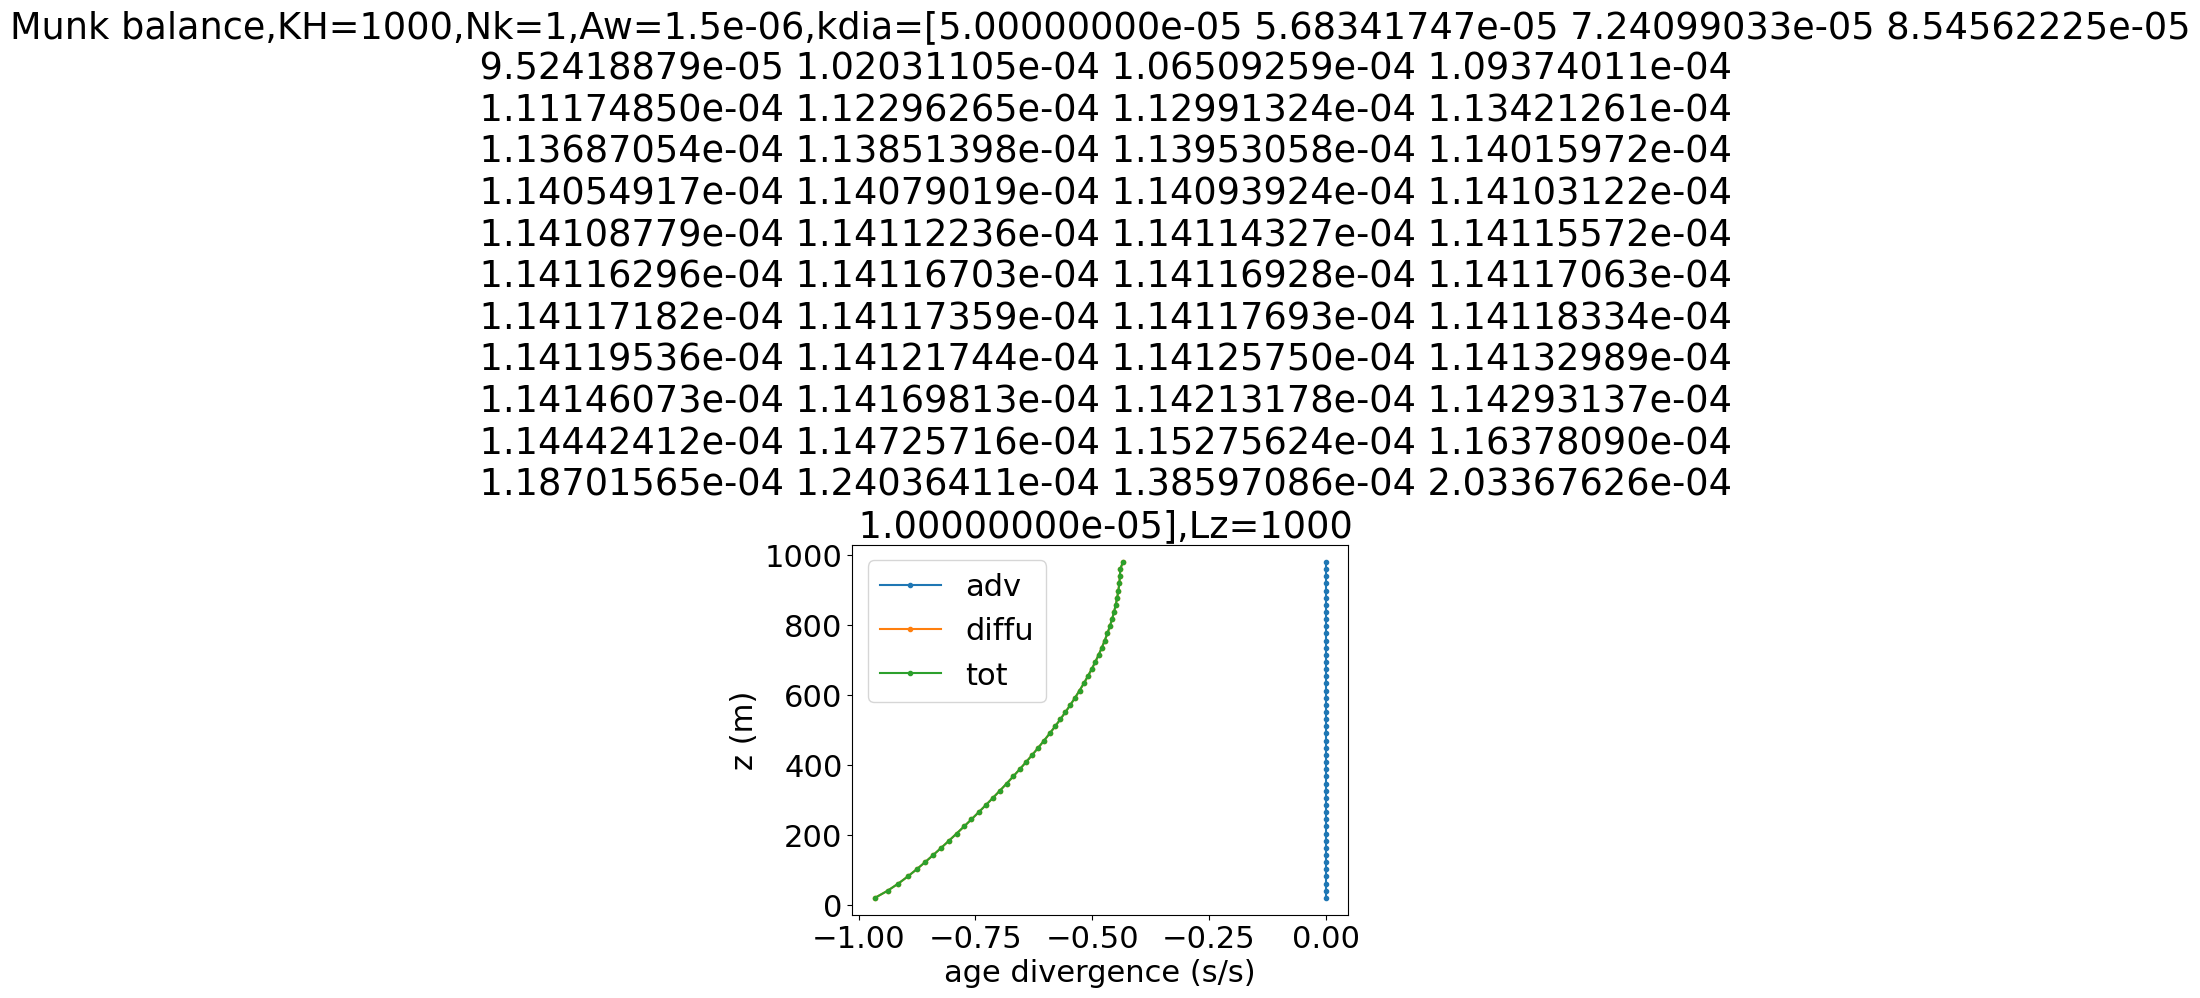

In [261]:
#age flux budget
advzmean=np.mean(advz,axis=0)
diffzmean=np.mean(diffz,axis=0)
plt.figure()
plt.plot(advzmean[1:],zgridu[1:],'.-',label='adv')
plt.plot(diffzmean[1:],zgridu[1:],'.-',label='diffu')
plt.plot(diffzmean[1:]+advzmean[1:],zgridu[1:],'.-',label='tot')
plt.legend()
plt.xlabel('age flux (m s/s)')
plt.ylabel('z (m)')
plt.title(f"age flux budget,KH={kiso},Nk={Nk},Aw={A},kdia={kdia},Lz={Lz}")

######"Munk balance"########
#calculate 
advzmean_pad=np.hstack((advzmean,0))
diffzmean_pad=np.hstack((diffzmean,0))
gradadvzmean=(-advzmean_pad[:-1]+advzmean_pad[1:])/(-dz)
graddiffzmean=(-diffzmean_pad[:-1]+diffzmean_pad[1:])/(-dz)

plt.figure()
plt.plot(gradadvzmean[1:],zgridu[1:],'.-',label='adv')
plt.plot(graddiffzmean[1:],zgridu[1:],'.-',label='diffu')
plt.plot(gradadvzmean[1:]+graddiffzmean[1:],zgridu[1:],'.-',label='tot')
plt.legend()
plt.xlabel('age divergence (s/s)')
plt.ylabel('z (m)')
plt.title(f"Munk balance,KH={kiso},Nk={Nk},Aw={A},kdia={kdia},Lz={Lz}")

array([5.00000000e-05, 5.68341747e-05, 7.24099033e-05, 8.54562225e-05,
       9.52418879e-05, 1.02031105e-04, 1.06509259e-04, 1.09374011e-04,
       1.11174850e-04, 1.12296265e-04, 1.12991324e-04, 1.13421261e-04,
       1.13687054e-04, 1.13851398e-04, 1.13953058e-04, 1.14015972e-04,
       1.14054917e-04, 1.14079019e-04, 1.14093924e-04, 1.14103122e-04,
       1.14108779e-04, 1.14112236e-04, 1.14114327e-04, 1.14115572e-04,
       1.14116296e-04, 1.14116703e-04, 1.14116928e-04, 1.14117063e-04,
       1.14117182e-04, 1.14117359e-04, 1.14117693e-04, 1.14118334e-04,
       1.14119536e-04, 1.14121744e-04, 1.14125750e-04, 1.14132989e-04,
       1.14146073e-04, 1.14169813e-04, 1.14213178e-04, 1.14293137e-04,
       1.14442412e-04, 1.14725716e-04, 1.15275624e-04, 1.16378090e-04,
       1.18701565e-04, 1.24036411e-04, 1.38597086e-04, 2.03367626e-04,
       1.00000000e-05])

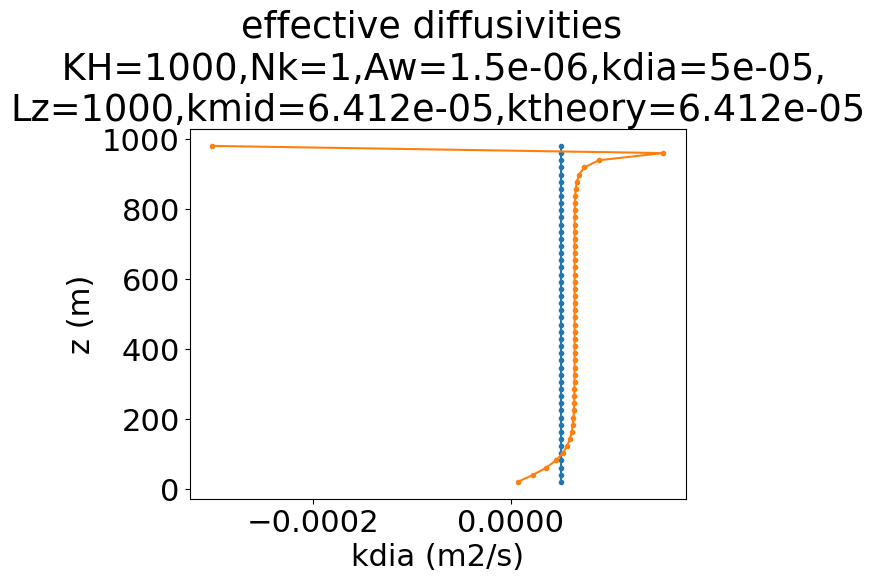

In [253]:
grad_zmean=np.mean(grad_z,axis=0)
keff_diff=-diffzmean/(grad_zmean+1e-30)
keff_shear=-advzmean/(grad_zmean+1e-30)

ktheory=A*A/2/kiso/alpha/alpha
ktheory

plt.figure()
plt.plot(keff_diff[1:],zgridu[1:],'.-',label='kdiff')
plt.plot(keff_shear[1:],zgridu[1:],'.-',label='kshear')
plt.title(f'effective diffusivities \n KH={kiso},Nk={Nk},Aw={A},kdia={kdia},\nLz={Lz},kmid={keff_shear[Nz//2]:.4g},ktheory={ktheory:.4g}')
plt.xlabel('kdia (m2/s)')
plt.ylabel('z (m)')

keff_shear_age=keff_shear
keff_shear_age
kdiatot_age=kdia+keff_shear_age
kdiatot_age[-1]=1e-5
kdiatot_age

Text(0.5, 1.0, 'agemean')

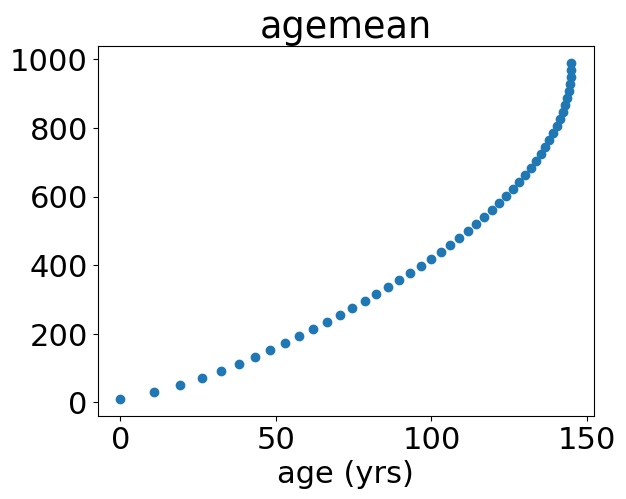

In [258]:
plt.figure()
agemean=np.mean(age,axis=0)
plt.plot(agemean/31104000,zgridt,'o')
plt.xlabel('age (yrs)')
plt.title('agemean')

In [262]:
Nyt=Ny-1
Nzt=Nz-1
v_basin_grid=v2d*0
w_basin_grid=w2d*0

kdia=kdiatot_age
kiso=1000

#dt=86400*10#s
#T=31104000*300#00#31104000*5000 #years->second
dt=8640*2
T=31104000*200
Nt=T//dt
#Nt=40000
kiso=1000#-500#m2/s
#kv=kv0
#kdia=0

tracer=np.zeros([Nyt,Nzt])

#tracer[0,:]=np.linspace(0,400*31104000,Nz)
tracer_source=np.ones([Nyt,Nzt])
tracer_yface=np.zeros([Nyt,Nzt])
tracer_zface=np.zeros([Nyt,Nzt])
grad_y=np.zeros([Nyt,Nzt])
grad_z=np.zeros([Nyt,Nzt])
advy_1=np.zeros([Nyt,Nzt])
advy_2=np.zeros([Nyt,Nzt])
advz_1=np.zeros([Nyt,Nzt])
advz_2=np.zeros([Nyt,Nzt])
##write a 2D solver here

#Age in shear flow
for it in range(0,Nt):
    ##advection: using centered 2nd order scheme
    ##advy is on the negative side of t grid
    ##advy_1: contribution from the negative side of t grid
    advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
    advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
    ##advy_2: contribution from the positive side of t grid
    advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
    advy=advy_1+advy_2
    ##tracer concentration on v grids
    tracer_yface[0,:]=(tracer[-1,:]+tracer[0,:])/2
    tracer_yface[1:,:]=(tracer[0:-1,:]+tracer[1:,:])/2
    advy=tracer_yface*v_basin_grid
    ##advz is on the top side of the t grid
    ##advz_1: contribution from the bottom side of t grid
    advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
    ##advz_2:contribution from the top side of t grid
    advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
    advz=advz_1+advz_2
    tracer_zface[:,1:]=(tracer[:,0:-1]+tracer[:,1:])/2
    advz=tracer_zface*w_basin_grid
    
#     #advection:upwind
#     #advy is on the negative side of t grid
#     #advy_1: contribution from the negative side of t grid
#     advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
#     advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
#     #advy_2: contribution from the positive side of t grid
#     advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
#     advy=advy_1+advy_2
#     #advz is on the top side of the t grid
#     #advz_1: contribution from the bottom side of t grid
#     advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
#     #advz_2:contribution from the top side of t grid
#     advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
#     advz=advz_1+advz_2
    
    grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
    grad_y[0,:]=(tracer[0,:]-tracer[-1,:])/dy
    grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/dz #w grid is on the upper Z surface

    diffy=-kiso*grad_y
    diffz=-kdia*grad_z

    fluxy=advy+diffy 
    fluxz=advz+diffz
    
    tracertop=tracer[:,-1]
    tracertop.shape=(Ny-1,1)
    fluxy=np.vstack((fluxy,fluxy[0,:]))
    fluxz=np.hstack((fluxz,0*tracertop/dz))
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])




Text(0.5, 1.0, 'KH=1000,Nk=1,Aw=0.0,kdia=keff')

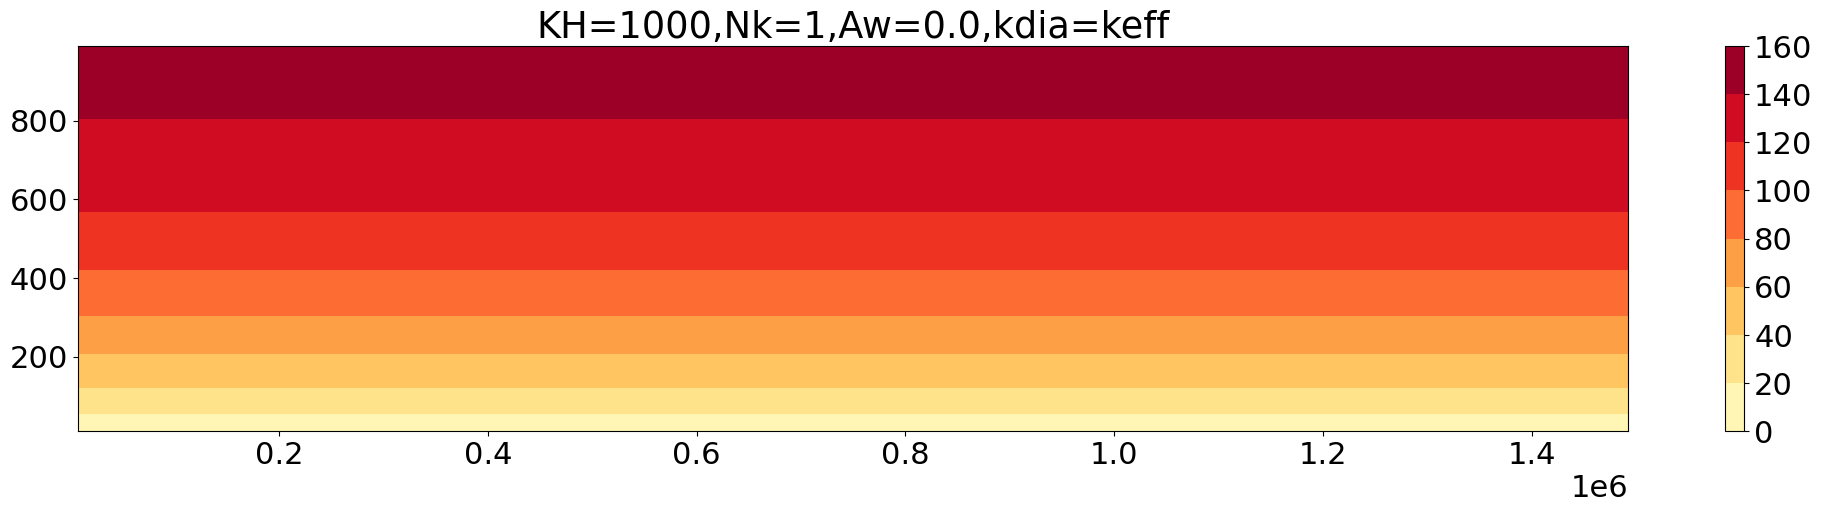

In [263]:
#plot age
ageeff=tracer

plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,ageeff.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A*0},kdia=keff")

Text(0.5, 1.0, 'agemean')

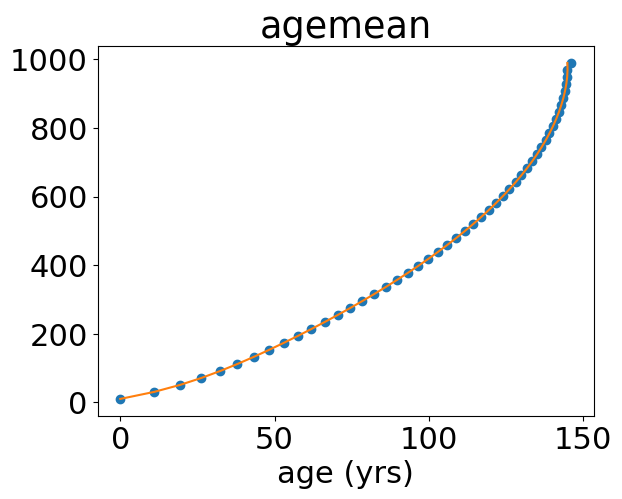

In [266]:
plt.figure()
ageeffmean=np.mean(ageeff,axis=0)
plt.plot(ageeffmean/31104000,zgridt,'o')
#agemean=np.mean(age,axis=0)
plt.plot(agemean/31104000,zgridt,'-')
plt.xlabel('age (yrs)')
plt.title('agemean')

/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_1495/1021994596.py:32: RuntimeWarning: invalid value encountered in true_divide
  mxl=tracer_zfaceprime/tracer_zgradmean
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


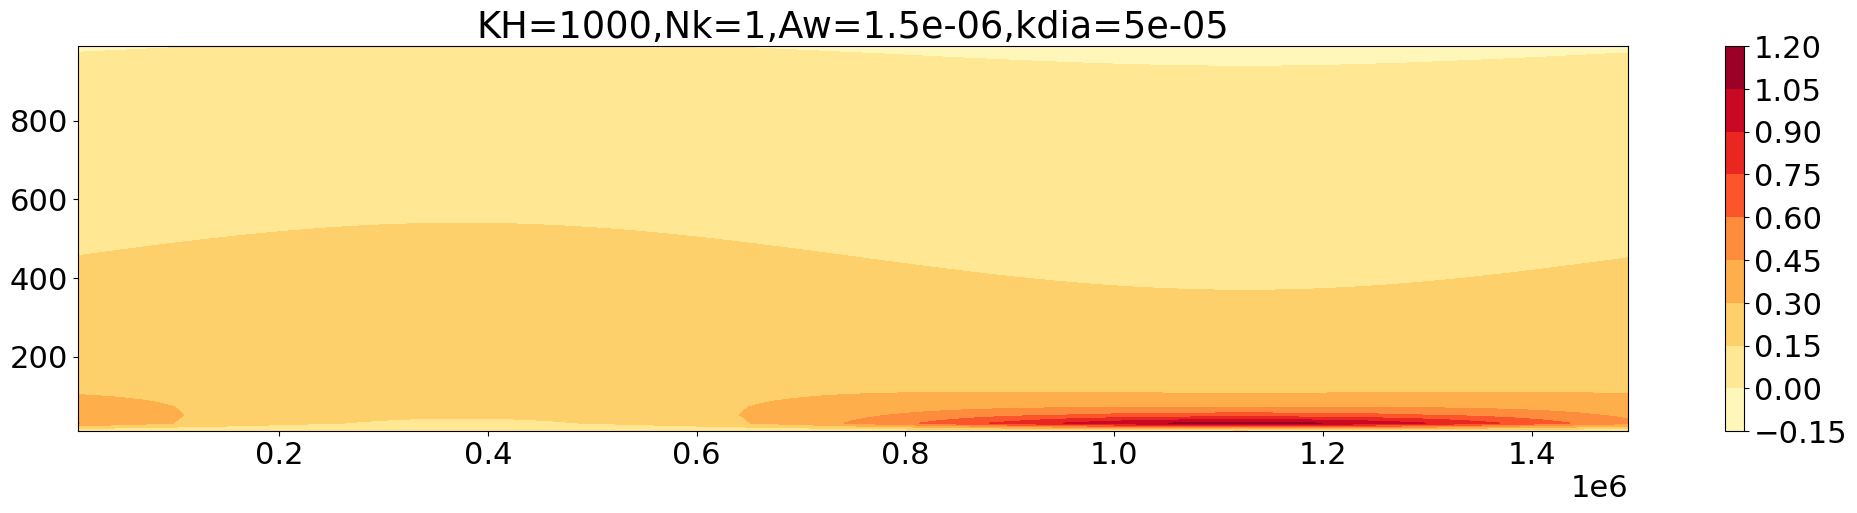

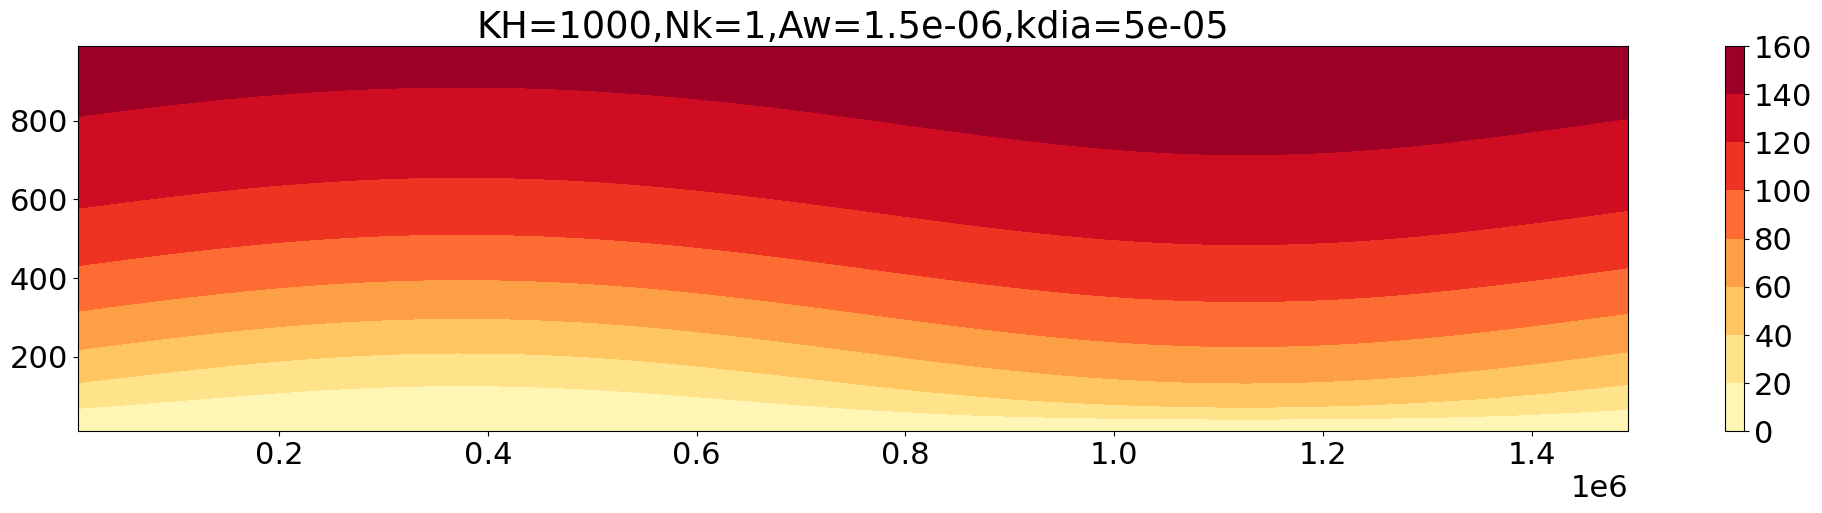

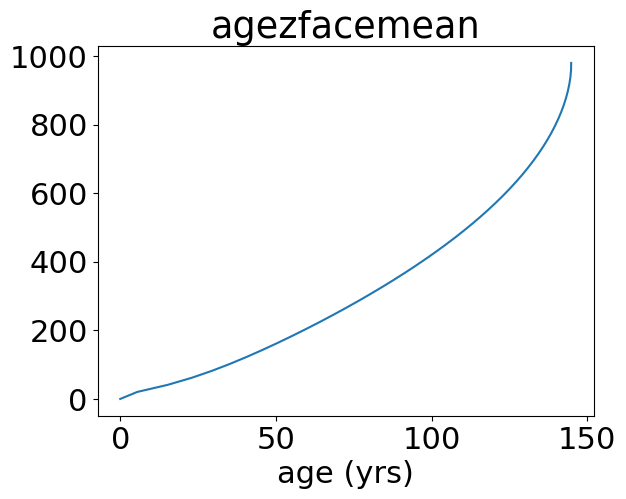

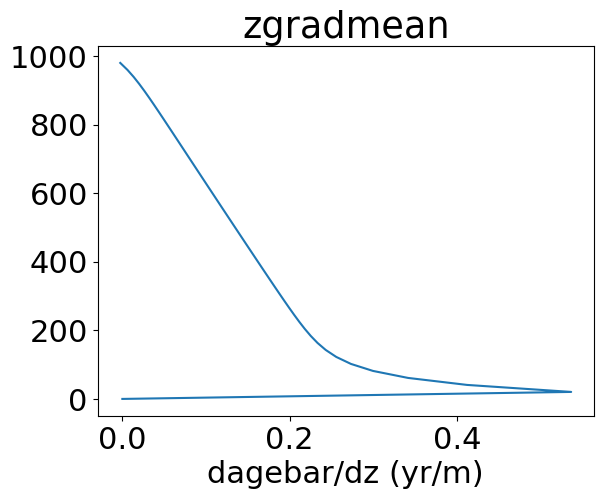

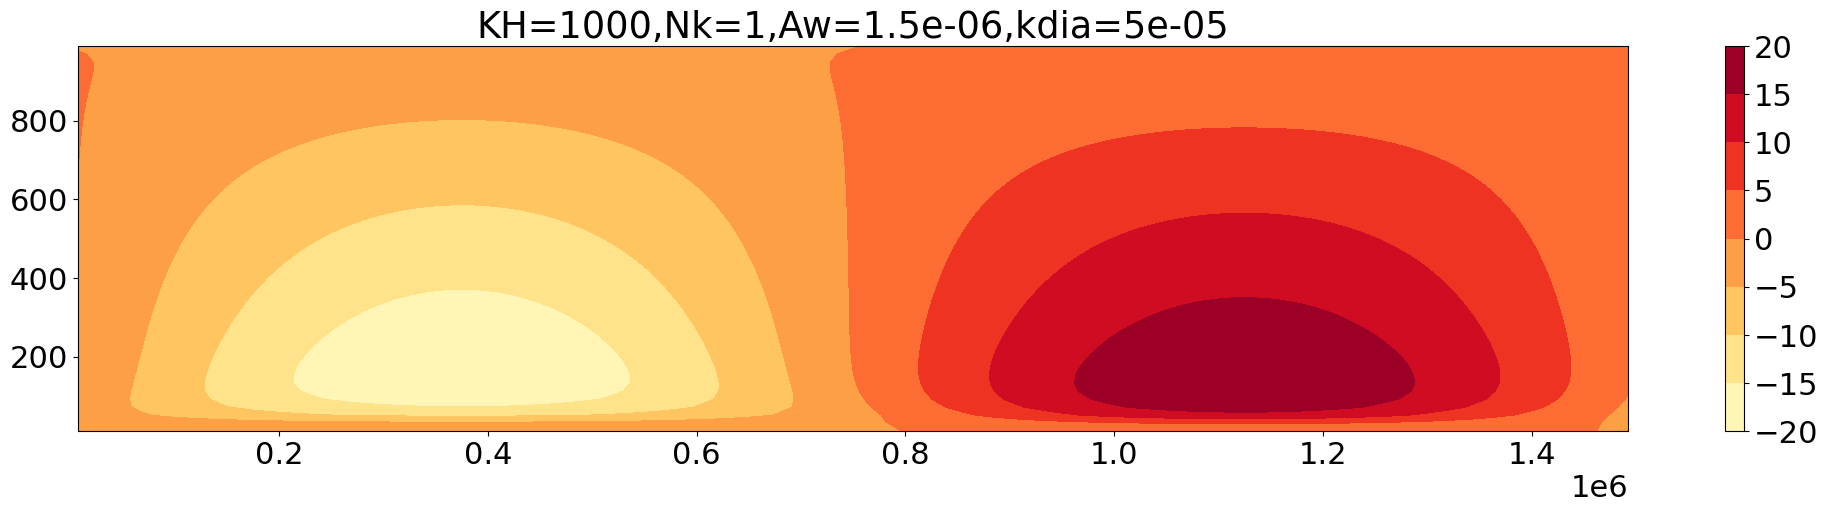

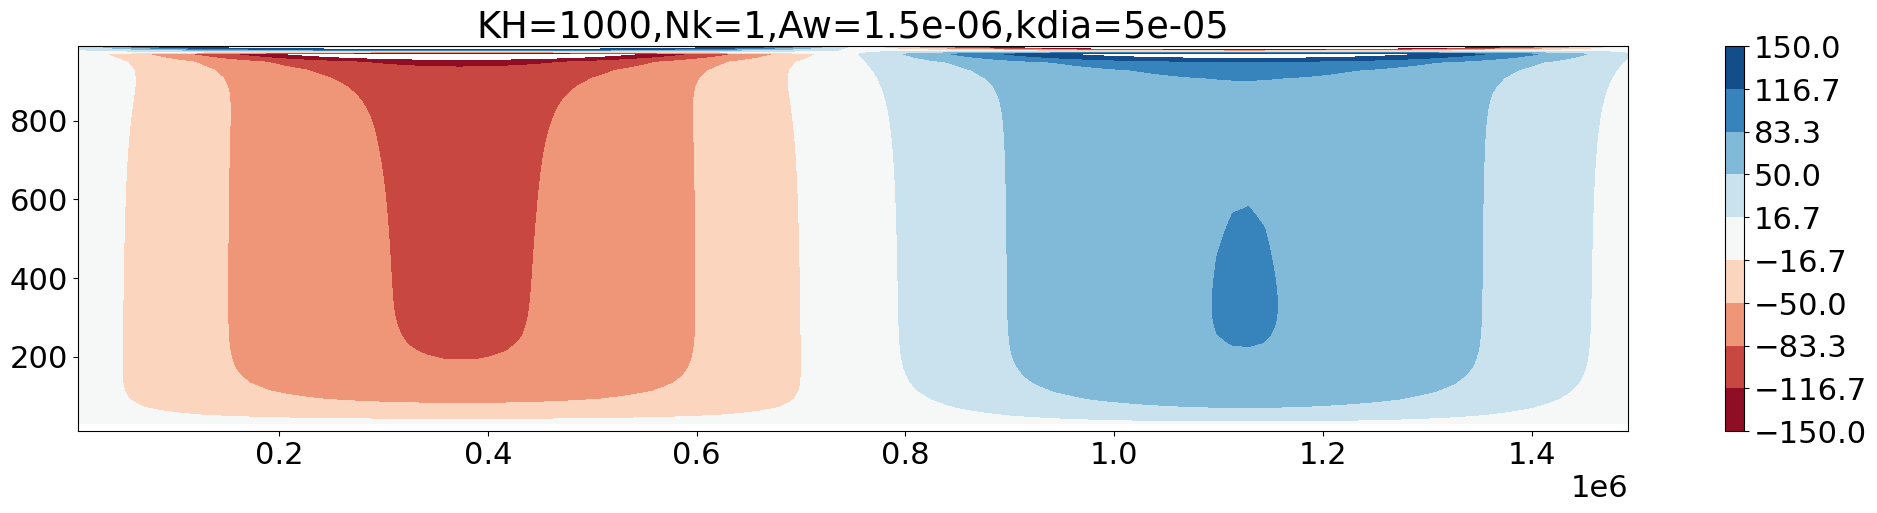

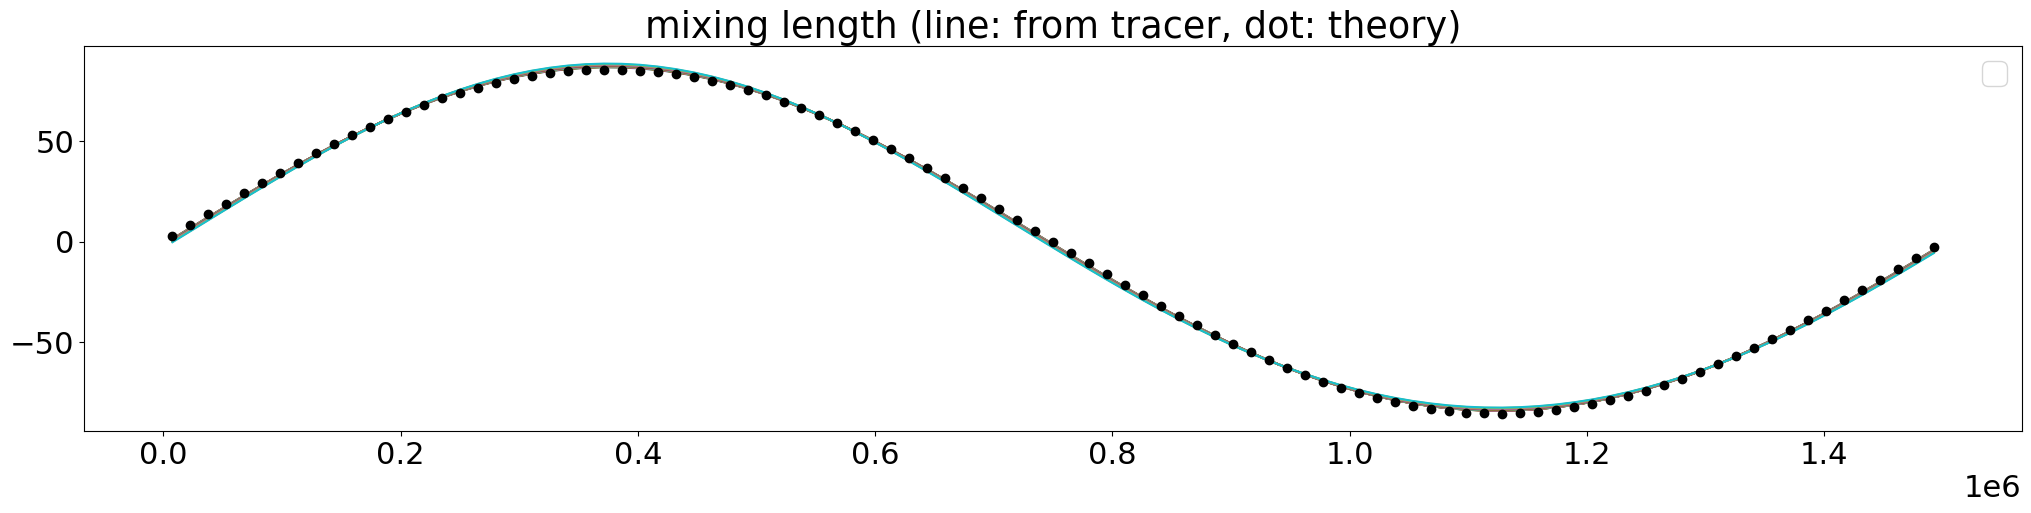

In [235]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,grad_z.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")

plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,tracer_zface.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")

plt.figure()
tracer_zfacemean=np.mean(tracer_zface,axis=0)
plt.plot(tracer_zfacemean/31104000,zgridu)
plt.xlabel('age (yrs)')
plt.title('agezfacemean')

tracer_zfaceprime=tracer_zface-tracer_zfacemean
tracer_zgradmean=np.mean(grad_z,axis=0)

plt.figure()
plt.plot(tracer_zgradmean/31104000,zgridu)
plt.xlabel('dagebar/dz (yr/m)')
plt.title('zgradmean')

plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,tracer_zfaceprime.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")

#mixing length mxl
mxl=tracer_zfaceprime/tracer_zgradmean
plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,(mxl).T,cmap=plt.cm.RdBu,levels=np.linspace(-150,150,10))
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")

plt.figure(figsize=(25,5))
plt.plot(np.squeeze(ygridt),-mxl[:,Nz//2-10:Nz//2+10])
plt.plot(np.squeeze(ygridt),np.squeeze(w2d[:,-1])/alpha/alpha/kiso,'ok',linewidth=2)
plt.title('mixing length (line: from tracer, dot: theory)')

plt.legend()





In [8]:
keff_diff

array([-0.e+00,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,
        5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,
        5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,
        5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,  5.e-05,
        5.e-05])

In [9]:
advzmean

array([   0.        ,  -67.69015107, -169.09634659, -218.79919757,
       -241.24397335, -248.91310221, -248.38977317, -243.2417612 ,
       -235.4466081 , -226.12055734, -215.90286075, -205.16377892,
       -194.11969046, -182.89799172, -171.57427278, -160.19393395,
       -148.78498965, -137.36590385, -125.9507353 , -114.55304807,
       -103.18966778,  -91.88530394,  -80.67928419,  -69.63621269,
        -58.86342313,  -48.53993077,  -38.96467115,  -30.63685383,
        -24.38900623])

In [10]:
grad_zmean

array([       0.        , 10102996.82479887,  7661759.66499512,
        6255116.07410977,  5394075.02269201,  4828937.61144822,
        4428008.5629992 ,  4119911.01646341,  3865078.18569852,
        3641172.04068575,  3435395.69740072,  3240332.56999117,
        3051643.70620169,  2866769.52397841,  2684186.14498487,
        2502972.98783008,  2322556.65889899,  2142554.23623332,
        1962670.37064086,  1782619.08790876,  1602048.6770725 ,
        1420449.24927023,  1237018.04215521,  1050446.21428674,
         858569.69647179,   657789.9776089 ,   442109.01898563,
         201521.63531009,   -80646.31117692])

In [11]:
keff_shear[1:]

array([ 6.70000716e-06,  2.20701711e-05,  3.49792386e-05,  4.47238817e-05,
        5.15461417e-05,  5.60951429e-05,  5.90405376e-05,  6.09163895e-05,
        6.21010364e-05,  6.28465772e-05,  6.33156549e-05,  6.36115186e-05,
        6.37993359e-05,  6.39204077e-05,  6.40014633e-05,  6.40608655e-05,
        6.41131513e-05,  6.41731476e-05,  6.42610914e-05,  6.44110689e-05,
        6.46874952e-05,  6.52207821e-05,  6.62920307e-05,  6.85598658e-05,
        7.37924450e-05,  8.81336265e-05,  1.52027616e-04, -3.02419365e-04])

In [12]:
zgridt[4],zgridt[9],zgridt[14],zgridt[19]

(93.10344827586206, 196.55172413793105, 300.0, 403.44827586206895)

In [13]:
np.log(2)

0.6931471805599453

In [218]:
#ideal radioactive tracer

#lambda=log2/(5370yrs)
lbd=np.log(2)/(50*31104000)
Nyt=Ny-1
Nzt=Nz-1
v_basin_grid=v2d
w_basin_grid=w2d

kdia=5e-5
kiso=1000

#dt=86400*10#s
#T=31104000*300#00#31104000*5000 #years->second
dt=8640*2
T=31104000*200
Nt=T//dt
#Nt=40000
kiso=1000#-500#m2/s
#kv=kv0
#kdia=0

#tracer=np.zeros([Nyt,Nzt])
#tracer[:,0]=tracer[:,0]+1

#tracer[0,:]=np.linspace(0,400*31104000,Nz)
tracer_source=np.ones([Nyt,Nzt])
tracer_yface=np.zeros([Nyt,Nzt])
tracer_zface=np.zeros([Nyt,Nzt])
grad_y=np.zeros([Nyt,Nzt])
grad_z=np.zeros([Nyt,Nzt])
advy_1=np.zeros([Nyt,Nzt])
advy_2=np.zeros([Nyt,Nzt])
advz_1=np.zeros([Nyt,Nzt])
advz_2=np.zeros([Nyt,Nzt])
##write a 2D solver here

#Age in shear flow
for it in range(0,Nt):
    ##advection: using centered 2nd order scheme
    ##advy is on the negative side of t grid
    ##advy_1: contribution from the negative side of t grid
    advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
    advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
    ##advy_2: contribution from the positive side of t grid
    advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
    advy=advy_1+advy_2
    ##tracer concentration on v grids
    tracer_yface[0,:]=(tracer[-1,:]+tracer[0,:])/2
    tracer_yface[1:,:]=(tracer[0:-1,:]+tracer[1:,:])/2
    advy=tracer_yface*v_basin_grid
    ##advz is on the top side of the t grid
    ##advz_1: contribution from the bottom side of t grid
    advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
    ##advz_2:contribution from the top side of t grid
    advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
    advz=advz_1+advz_2
    tracer_zface[:,1:]=(tracer[:,0:-1]+tracer[:,1:])/2
    advz=tracer_zface*w_basin_grid
    
#     #advection:upwind
#     #advy is on the negative side of t grid
#     #advy_1: contribution from the negative side of t grid
#     advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
#     advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
#     #advy_2: contribution from the positive side of t grid
#     advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
#     advy=advy_1+advy_2
#     #advz is on the top side of the t grid
#     #advz_1: contribution from the bottom side of t grid
#     advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
#     #advz_2:contribution from the top side of t grid
#     advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
#     advz=advz_1+advz_2
    
    grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
    grad_y[0,:]=(tracer[0,:]-tracer[-1,:])/dy
    grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/dz #w grid is on the upper Z surface

    diffy=-kiso*grad_y
    diffz=-kdia*grad_z

    fluxy=advy+diffy 
    fluxz=advz+diffz
    
    tracertop=tracer[:,-1]
    tracertop.shape=(Ny-1,1)
    fluxy=np.vstack((fluxy,fluxy[0,:]))
    fluxz=np.hstack((fluxz,0*kdia*tracertop/dz))
    
    tracer_source=0*tracer_source-tracer*lbd
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])


Text(0.5, 1.0, 'KH=1000,Nk=1,Aw=1.5e-06,kdia=5e-05')

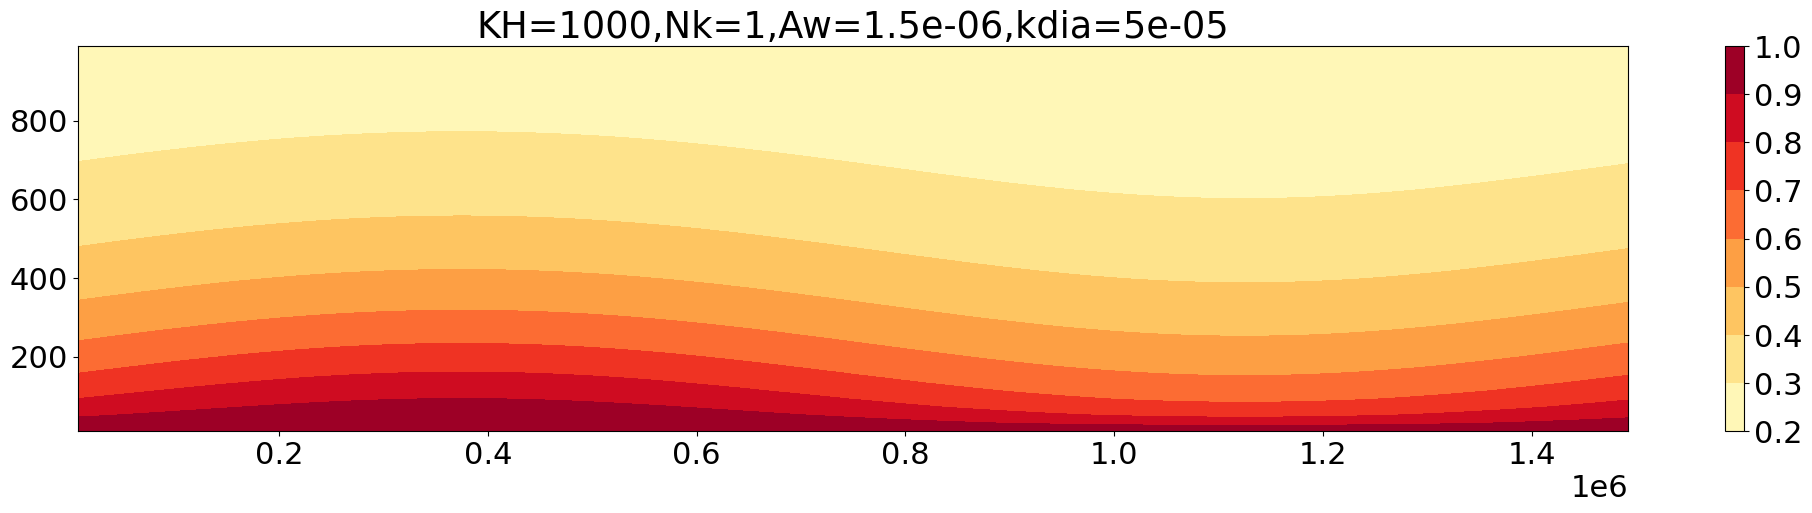

In [108]:
radioC=tracer
plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,radioC.T,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")

Text(0, 0.5, 'ideal Delta radiocarbon 1/1000')

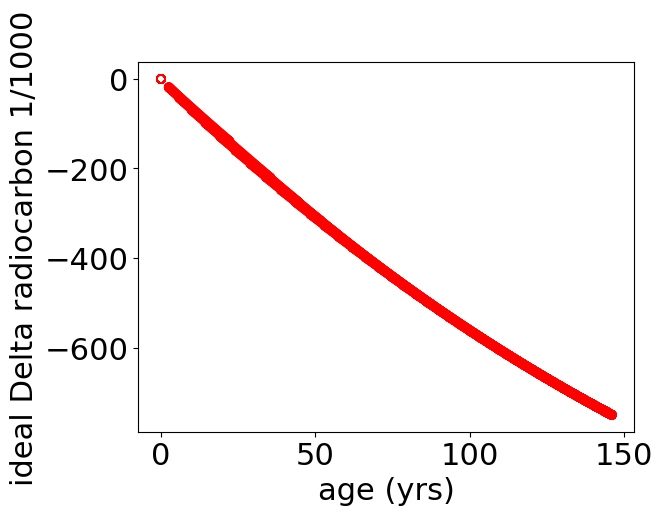

In [109]:
vecradio=radioC[:,:].flatten()
vecage=age[:,:].flatten()
plt.scatter(vecage/31104000,(vecradio-1)*1000, facecolors='none', edgecolors='r')
plt.xlabel('age (yrs)')
plt.ylabel('ideal Delta radiocarbon 1/1000')

Text(0.5, 1.0, 'KH=1000,Nk=1,Aw=1.5e-06,kdia=5e-05')

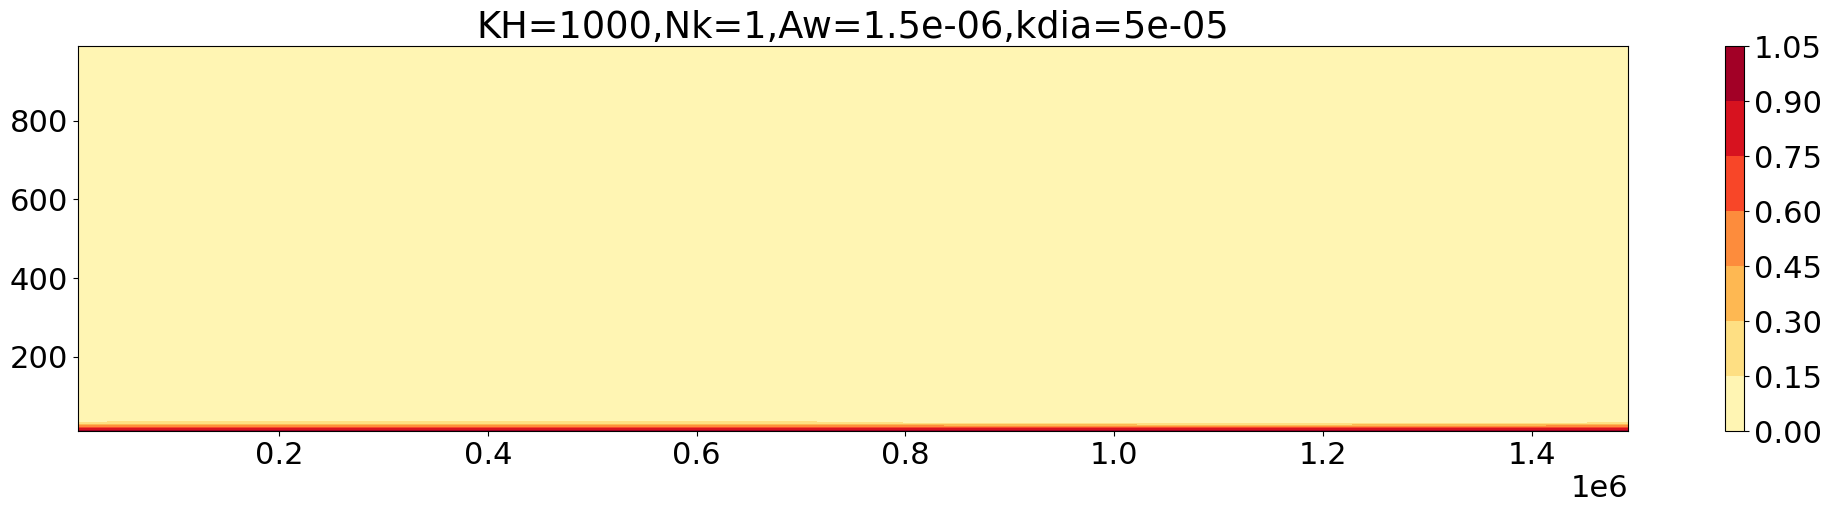

In [313]:
Nyt=Ny-1
Nzt=Nz-1
v_basin_grid=v2d
w_basin_grid=w2d

kdia=5e-5
#kdia=kdiatot_age
kiso=1000

#dt=86400*10#s
#T=31104000*300#00#31104000*5000 #years->second
dt=8640*2
T0=86400*10
T=T0
Nt=T//dt
#Nt=40000
kiso=1000#-500#m2/s
#kv=kv0
#kdia=0
tracer=np.zeros([Nyt,Nzt])
tracer[:,0]=tracer[:,0]+1
#tracer[0,:]=np.linspace(0,400*31104000,Nz)
tracer_source=np.ones([Nyt,Nzt])*0
tracer_yface=np.zeros([Nyt,Nzt])
tracer_zface=np.zeros([Nyt,Nzt])
grad_y=np.zeros([Nyt,Nzt])
grad_z=np.zeros([Nyt,Nzt])
advy_1=np.zeros([Nyt,Nzt])
advy_2=np.zeros([Nyt,Nzt])
advz_1=np.zeros([Nyt,Nzt])
advz_2=np.zeros([Nyt,Nzt])
##write a 2D solver here

#Age in shear flow
for it in range(0,Nt):
    ##advection: using centered 2nd order scheme
    #tracer_yface[1:,:]=(tracer[:-1,:]+tracer[1:,:])/2 #v surface is at the negative(south) side of the t grid
    #advy=v_basin_grid*tracer_yface
    #tracer_zface[:,:-1]=(tracer[:,:-1]+tracer[:,1:])/2 #w surface is at the top of t grid
    
    #advection:upwind
    #advy is on the negative side of t grid
    #advy_1: contribution from the negative side of t grid
    advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
    advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
    #advy_2: contribution from the positive side of t grid
    advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
    advy=advy_1+advy_2
    #advz is on the top side of the t grid
    #advz_1: contribution from the bottom side of t grid
    advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
    #advz_2:contribution from the top side of t grid
    advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
    advz=advz_1+advz_2
    
    grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
    grad_y[0,:]=(tracer[0,:]-tracer[-1,:])/dy
    grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/dz #w grid is on the upper Z surface

    diffy=-kiso*grad_y
    diffz=-kdia*grad_z

    fluxy=advy+diffy 
    fluxz=advz+diffz
    
    tracertop=tracer[:,-1]
    tracertop.shape=(Ny-1,1)
    fluxy=np.vstack((fluxy,fluxy[0,:]))
    fluxz=np.hstack((fluxz,0*tracertop/dz))
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])

plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,tracer.T,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")


In [314]:
yi=[24,74]
#zi=[4,9,14,19]
Nyi=len(yi)
Nzi=Nzt
Ttot=200*31104000
dti=86400*50
Nti=Ttot//dti
Gmatrix=np.zeros([Nyi,Nzi,Nti])
Gmatrixmean=np.zeros([Nzi,Nti])

In [315]:

dt=8640*2
T=31104000*199
Nt=T//dt


tracer[:,0]=tracer[:,0]*0
ti=T0

##write a 2D solver here

#Age in shear flow
for it in range(0,Nt):
    ##advection: using centered 2nd order scheme
    #tracer_yface[1:,:]=(tracer[:-1,:]+tracer[1:,:])/2 #v surface is at the negative(south) side of the t grid
    #advy=v_basin_grid*tracer_yface
    #tracer_zface[:,:-1]=(tracer[:,:-1]+tracer[:,1:])/2 #w surface is at the top of t grid
    
    #advection:upwind
    #advy is on the negative side of t grid
    #advy_1: contribution from the negative side of t grid
    advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
    advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
    #advy_2: contribution from the positive side of t grid
    advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
    advy=advy_1+advy_2
    #advz is on the top side of the t grid
    #advz_1: contribution from the bottom side of t grid
    advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
    #advz_2:contribution from the top side of t grid
    advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
    advz=advz_1+advz_2
    
    grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
    grad_y[0,:]=(tracer[0,:]-tracer[-1,:])/dy
    grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/dz #w grid is on the upper Z surface

    diffy=-kiso*grad_y
    diffz=-kdia*grad_z

    fluxy=advy+diffy 
    fluxz=advz+diffz
    
    tracertop=tracer[:,-1]
    tracertop.shape=(Ny-1,1)
    fluxy=np.vstack((fluxy,fluxy[0,:]))
    fluxz=np.hstack((fluxz,0*tracertop/dz))
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    
    ti=ti+dt
    if (ti%dti==0):
        it=ti//dti
        Gmatrixmean[:,it]=np.mean(tracer,axis=0)
        for iy in range(Nyi):
            #for iz in range(Nzi):
            Gmatrix[iy,:,it]=tracer[yi[iy],:]
                
        
    if (ti%(31104000*50)==0):
        print("ti:(yrs)",ti/31104000)
        
    if((ti<31104000*20 and ti%8640000==0) or (ti<=31104000*40 and ti%(31104000*2)==0) or (ti<=31104000*500 and ti%(31104000*10)==0) ) :
        print("ti:",ti)
#         plt.figure(figsize=(25,5))
#         plt.contourf(ygridt,zgridt,tracer.T,cmap=plt.cm.YlOrRd)
#         plt.colorbar()
#         plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia},ti={ti/31104000}")


ti: 8640000
ti: 17280000
ti: 25920000
ti: 34560000
ti: 43200000
ti: 51840000
ti: 60480000
ti: 62208000
ti: 69120000
ti: 77760000
ti: 86400000
ti: 95040000
ti: 103680000
ti: 112320000
ti: 120960000
ti: 124416000
ti: 129600000
ti: 138240000
ti: 146880000
ti: 155520000
ti: 164160000
ti: 172800000
ti: 181440000
ti: 186624000
ti: 190080000
ti: 198720000
ti: 207360000
ti: 216000000
ti: 224640000
ti: 233280000
ti: 241920000
ti: 248832000
ti: 250560000
ti: 259200000
ti: 267840000
ti: 276480000
ti: 285120000
ti: 293760000
ti: 302400000
ti: 311040000
ti: 319680000
ti: 328320000
ti: 336960000
ti: 345600000
ti: 354240000
ti: 362880000
ti: 371520000
ti: 373248000
ti: 380160000
ti: 388800000
ti: 397440000
ti: 406080000
ti: 414720000
ti: 423360000
ti: 432000000
ti: 435456000
ti: 440640000
ti: 449280000
ti: 457920000
ti: 466560000
ti: 475200000
ti: 483840000
ti: 492480000
ti: 497664000
ti: 501120000
ti: 509760000
ti: 518400000
ti: 527040000
ti: 535680000
ti: 544320000
ti: 552960000
ti: 559872000
ti: 5

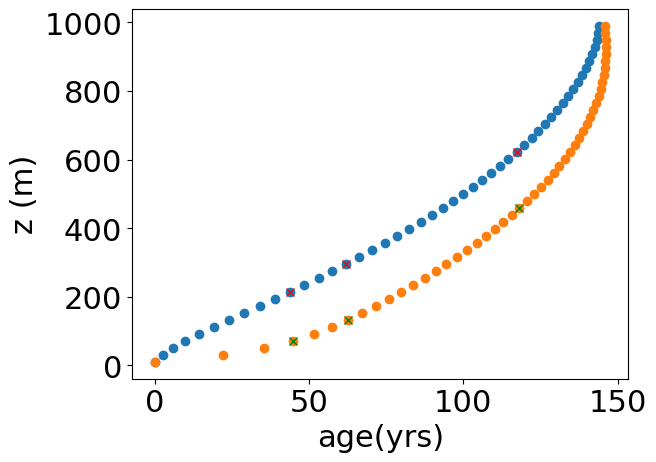

In [183]:
#label isochrons by hand
plt.plot(age[yi[0],:]/31104000,zgridt,'o')
plt.plot(age[yi[1],:]/31104000,zgridt,'o')
plt.ylabel('z (m)')
plt.xlabel('age(yrs)')
#z young 1
zy=[10,14,30]
zo=[3,6,22]

plt.plot(age[yi[1],zo[0]]/31104000,zgridt[zo[0]],'gx')
plt.plot(age[yi[0],zy[0]]/31104000,zgridt[zy[0]],'rx')

plt.plot(age[yi[1],zo[1]]/31104000,zgridt[zo[1]],'gx')
plt.plot(age[yi[0],zy[1]]/31104000,zgridt[zy[1]],'rx')

plt.plot(age[yi[1],zo[2]]/31104000,zgridt[zo[2]],'gx')
plt.plot(age[yi[0],zy[2]]/31104000,zgridt[zy[2]],'rx')

In [ ]:
#calculate isochron depth
#to be implemented

In [316]:
#Gmatrixageshear=Gmatrix*1
#Gmatrixageshearmean=Gmatrixmean*1
#Gmatrixageeff=Gmatrix*1
#Gmatrixageeffmean=Gmatrixmean*1

Text(0.5, 1.0, 'TTD')

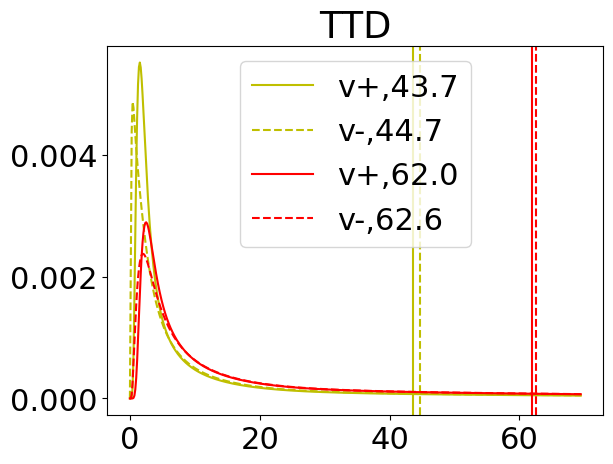

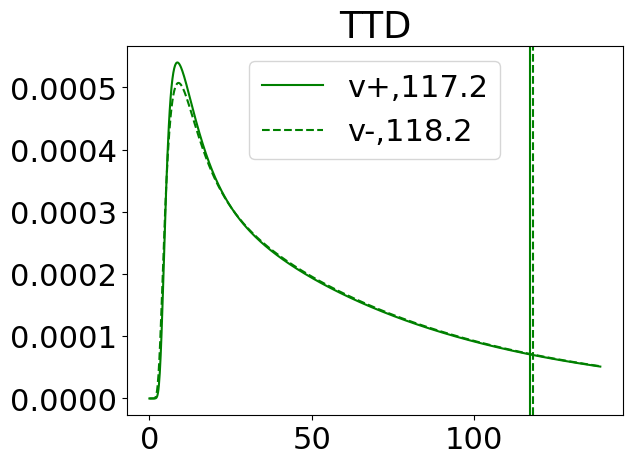

In [317]:
Ntlength=500
tG=np.linspace(0,Ntlength*dti,Ntlength)/31104000
plt.plot(tG,Gmatrix[0,zy[0],0:Ntlength],'y-',label=f'v+,{age[yi[0],zy[0]]/31104000:.1f}')
#plt.plot(Gmatrix[0,1,0:200],'o-')
#plt.plot(Gmatrix[1,2,0:800],'o-')
plt.plot(tG,Gmatrix[1,zo[0],0:Ntlength],'y--',label=f'v-,{age[yi[1],zo[0]]/31104000:.1f}')


plt.axvline(x=age[yi[0],zy[0]]/31104000,ls='-',color='y')
plt.axvline(x=age[yi[1],zo[0]]/31104000,ls='--',color='y')
plt.legend()
plt.title('TTD')
#plt.figure()
plt.plot(tG,Gmatrix[0,zy[1],0:Ntlength],'r-',label=f'v+,{age[yi[0],zy[1]]/31104000:.1f}')
#plt.plot(Gmatrix[0,1,0:200],'o-')
#plt.plot(Gmatrix[1,2,0:800],'o-')
plt.plot(tG,Gmatrix[1,zo[1],0:Ntlength],'r--',label=f'v-,{age[yi[1],zo[1]]/31104000:.1f}')
plt.axvline(x=age[yi[0],zy[1]]/31104000,ls='-',color='r')
plt.axvline(x=age[yi[1],zo[1]]/31104000,ls='--',color='r')

plt.legend()
plt.title('TTD')

Ntlength=1000
tG=np.linspace(0,Ntlength*dti,Ntlength)/31104000
plt.figure()
plt.plot(tG,Gmatrix[0,zy[2],0:Ntlength],'g-',label=f'v+,{age[yi[0],zy[2]]/31104000:.1f}')
#plt.plot(Gmatrix[0,1,0:200],'o-')
#plt.plot(Gmatrix[1,2,0:800],'o-')
plt.plot(tG,Gmatrix[1,zo[2],0:Ntlength],'g--',label=f'v-,{age[yi[1],zo[2]]/31104000:.1f}')

plt.axvline(x=age[yi[0],zy[2]]/31104000,ls='-',color='g')
plt.axvline(x=age[yi[1],zo[2]]/31104000,ls='--',color='g')
plt.legend()
plt.title('TTD')

###################


In [276]:
zgridt[5],zgridt[8],zgridt[15],zgridt[22]

(112.24489795918367, 173.46938775510205, 316.3265306122449, 459.1836734693877)

Text(0.5, 0, 't(years)')

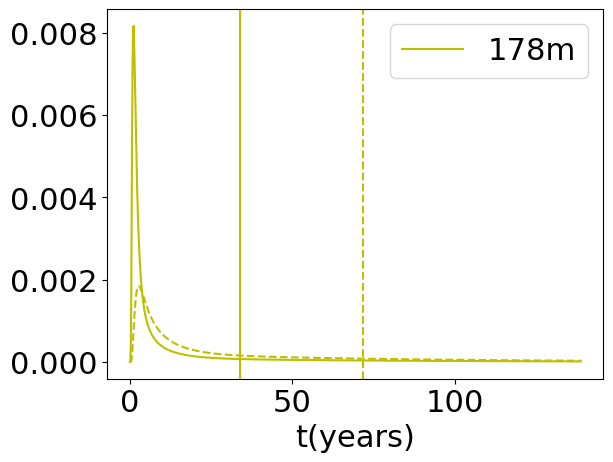

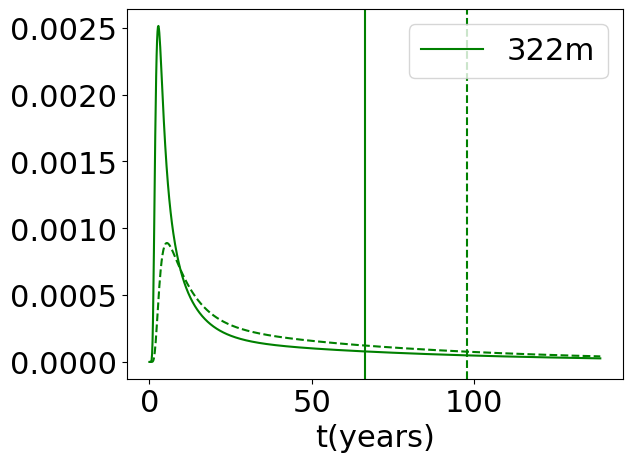

In [326]:
#plt.plot(Gmatrix[0,0,0:100],'o-')
#plt.plot(Gmatrix[0,1,0:200],'o-')
#plt.plot(Gmatrix[0,5,0:150],'b-',label='114m')
Ntlength=1000
tG=np.linspace(0,Ntlength*dti,Ntlength)/31104000
plt.plot(tG,Gmatrix[0,8,0:Ntlength],'y-',label='178m')

plt.axvline(x=age[yi[0],8]/31104000,ls='-',color='y')
plt.axvline(x=age[yi[1],8]/31104000,ls='--',color='y')
plt.plot(tG,Gmatrix[1,8,0:Ntlength],'y--')
#plt.plot(tG,Gmatrixmean[8,0:Ntlength],'yx',linewidth=2)
plt.legend()
plt.xlabel('t(years)')
plt.figure()
plt.plot(tG,Gmatrix[0,15,0:Ntlength],'g-',label='322m')
#plt.plot(tG,Gmatrix[0,22,0:Ntlength],'r-',label='469m')
plt.axvline(x=age[yi[0],15]/31104000,ls='-',color='g')
plt.axvline(x=age[yi[1],15]/31104000,ls='--',color='g')

#plt.axvline(x=age[yi[0],22]/31104000,ls='-',color='r')
#plt.axvline(x=age[yi[1],22]/31104000,ls='--',color='r')
#plt.plot(Gmatrix[2,5,0:150],'b--')

plt.plot(tG,Gmatrix[1,15,0:Ntlength],'g--')
#plt.plot(tG,Gmatrix[1,22,0:Ntlength],'r--')
plt.legend()
plt.xlabel('t(years)')
#plt.plot(Gmatrix[0,25,0:60],'b-')
#plt.plot(Gmatrix[0,21,0:70],'b-')

Text(0.5, 0, 't(years)')

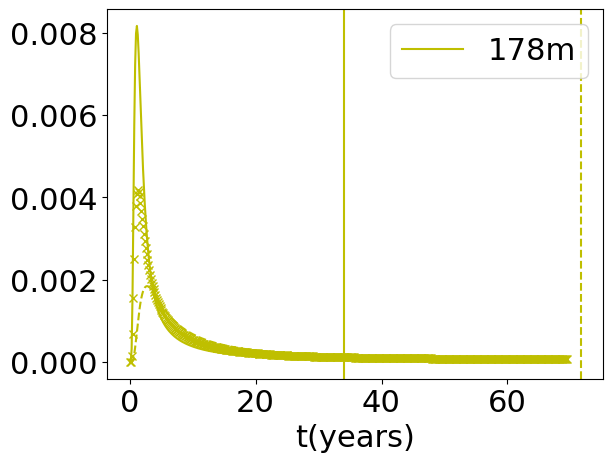

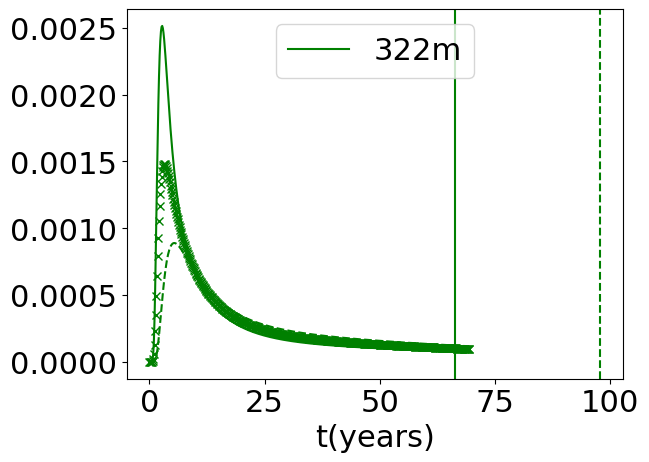

In [328]:
#plt.plot(Gmatrix[0,0,0:100],'o-')
#plt.plot(Gmatrix[0,1,0:200],'o-')
#plt.plot(Gmatrix[0,5,0:150],'b-',label='114m')
Ntlength=500
tG=np.linspace(0,Ntlength*dti,Ntlength)/31104000
plt.plot(tG,Gmatrix[0,8,0:Ntlength],'y-',label='178m')

plt.axvline(x=age[yi[0],8]/31104000,ls='-',color='y')
plt.axvline(x=age[yi[1],8]/31104000,ls='--',color='y')
plt.plot(tG,Gmatrix[1,8,0:Ntlength],'y--')
plt.plot(tG,Gmatrixmean[8,0:Ntlength],'yx',linewidth=2)
plt.legend()
plt.xlabel('t(years)')
plt.figure()
plt.plot(tG,Gmatrix[0,15,0:Ntlength],'g-',label='322m')
#plt.plot(tG,Gmatrix[0,22,0:Ntlength],'r-',label='469m')
plt.axvline(x=age[yi[0],15]/31104000,ls='-',color='g')
plt.axvline(x=age[yi[1],15]/31104000,ls='--',color='g')
plt.plot(tG,Gmatrixmean[15,0:Ntlength],'gx',linewidth=2)

#plt.axvline(x=age[yi[0],22]/31104000,ls='-',color='r')
#plt.axvline(x=age[yi[1],22]/31104000,ls='--',color='r')
#plt.plot(Gmatrix[2,5,0:150],'b--')

plt.plot(tG,Gmatrix[1,15,0:Ntlength],'g--')
#plt.plot(tG,Gmatrix[1,22,0:Ntlength],'r--')
plt.legend()
plt.xlabel('t(years)')
#plt.plot(Gmatrix[0,25,0:60],'b-')
#plt.plot(Gmatrix[0,21,0:70],'b-')

Text(0.5, 0, 't(years)')

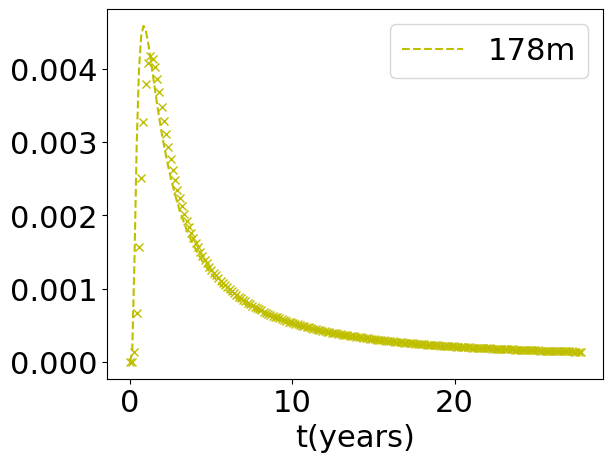

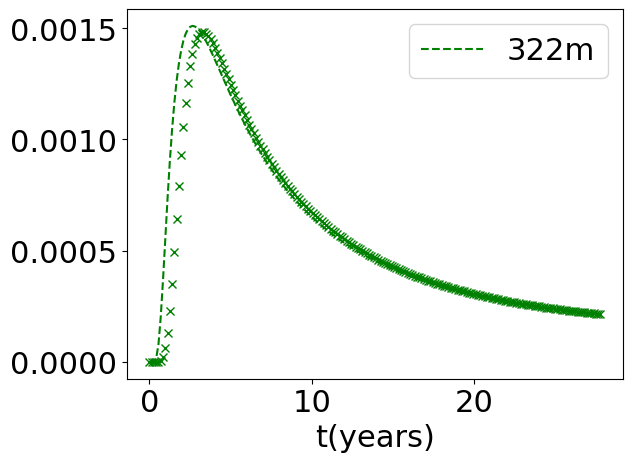

In [329]:
#plt.plot(Gmatrix[0,0,0:100],'o-')
#plt.plot(Gmatrix[0,1,0:200],'o-')
#plt.plot(Gmatrix[0,5,0:150],'b-',label='114m')
Ntlength=200
tG=np.linspace(0,Ntlength*dti,Ntlength)/31104000
#plt.plot(tG,Gmatrixageshear[0,8,0:Ntlength],'y-',label='178m')

#plt.axvline(x=age[yi[0],8]/31104000,ls='-',color='y')
#plt.axvline(x=age[yi[1],8]/31104000,ls='--',color='y')
plt.plot(tG,Gmatrixageeffmean[8,0:Ntlength],'y--',label='178m')
plt.plot(tG,Gmatrixageshearmean[8,0:Ntlength],'yx',linewidth=2)
plt.legend()
plt.xlabel('t(years)')
plt.figure()
#plt.plot(tG,Gmatrix[0,15,0:Ntlength],'g-',label='322m')
#plt.plot(tG,Gmatrix[0,22,0:Ntlength],'r-',label='469m')
#plt.axvline(x=age[yi[0],15]/31104000,ls='-',color='g')
#plt.axvline(x=age[yi[1],15]/31104000,ls='--',color='g')
plt.plot(tG,Gmatrixageeffmean[15,0:Ntlength],'g--',label='322m')
plt.plot(tG,Gmatrixageshearmean[15,0:Ntlength],'gx',linewidth=2)

#plt.axvline(x=age[yi[0],22]/31104000,ls='-',color='r')
#plt.axvline(x=age[yi[1],22]/31104000,ls='--',color='r')
#plt.plot(Gmatrix[2,5,0:150],'b--')

#plt.plot(tG,Gmatrix[1,15,0:Ntlength],'g--')
#plt.plot(tG,Gmatrix[1,22,0:Ntlength],'r--')
plt.legend()
plt.xlabel('t(years)')
#plt.plot(Gmatrix[0,25,0:60],'b-')
#plt.plot(Gmatrix[0,21,0:70],'b-')

/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_1495/3400312610.py:3: RuntimeWarning: divide by zero encountered in log
  plt.contourf(np.log(Gtemp),np.linspace(-70,0,30))


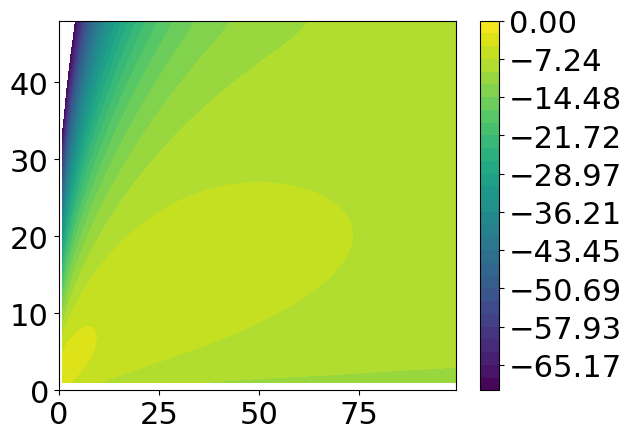

In [131]:
Gtemp=Gmatrix[0,:,0:100]
Gtemp.shape
plt.contourf(np.log(Gtemp),np.linspace(-70,0,30))
plt.colorbar()

In [ ]:
plt.plot(Gmatrix[2,0,0:300],'o-')
#plt.plot(Gmatrix[0,1,0:200],'o-')
plt.plot(Gmatrix[2,1,0:300],'o-')
plt.plot(Gmatrix[2,2,0:300],'o-')
plt.plot(Gmatrix[2,3,0:300],'o-')

In [ ]:
def tracer_integrate(Nyt,Nzt,tracer_init,tracer_source,dt=86400*10,T=31104000*1000):
    """
    integrate tracers
    Nyt,Nzt:number of grids
    tracer_init: initial tracer concentration
    tracer_source: source term for tracer
    """
    advy_1=np.zeros([Nyt,Nzt])
    advy_2=np.zeros([Nyt,Nzt])
    advz_1=np.zeros([Nyt,Nzt])
    advz_2=np.zeros([Nyt,Nzt])
    grad_y=np.zeros([Nyt,Nzt])
    grad_z=np.zeros([Nyt,Nzt])
    tendency=np.zeros([Nyt,Nzt])
    ten_ydiff=np.zeros([Nyt,Nzt])
    ten_zdiff=np.zeros([Nyt,Nzt])
    ten_yadv=np.zeros([Nyt,Nzt])
    ten_zadv=np.zeros([Nyt,Nzt])
    
    
    
    Nt=T//dt
    kdia=1e-4
    kiso=500
    
    tracer=np.copy(tracer_init)
    for it in range(0,Nt):
        ##advection: using centered 2nd order scheme
        tracer_yface[1:,:]=(tracer[:-1,:]+tracer[1:,:])/2 #v surface is at the negative(south) side of the t grid
        advy=v_basin_grid*tracer_yface
        tracer_zface[:,1:]=(tracer[:,:-1]+tracer[:,1:])/2 #w surface is at the top of t grid
        advz=w_basin_grid*tracer_zface
#         #advection:upwind
#         #advy is on the negative side of t grid
#         #advy_1: contribution from the negative side of t grid
#         advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
#         #advy_2: contribution from the positive side of t grid
#         advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
#         advy=advy_1+advy_2
#         #advz is on the top side of the t grid
#         #advz_1: contribution from the bottom side of t grid
#         advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
#         #advz_2:contribution from the top side of t grid
#         advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
#         advz=advz_1+advz_2

        grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
        grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/(dz) #w grid is on the upper Z surface

        diffy=-kiso*grad_y
        diffz=-kdia*grad_z

        fluxy=advy+diffy 
        fluxz=advz+diffz
        
        fluxy=np.vstack((fluxy,np.zeros([1,Nzt])))
        fluxz=np.hstack((fluxz,np.zeros([Nyt,1])))
        
        diffy=np.vstack((diffy,np.zeros([1,Nzt])))
        diffz=np.hstack((diffz,np.zeros([Nyt,1])))
        
        advy=np.vstack((advy,np.zeros([1,Nzt])))
        advz=np.hstack((advz,np.zeros([Nyt,1])))
        tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
        #tracer[:,1:]=tracer[:,1:]+0*dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz))
        
#         tendency[:,1:]=dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
#         ten_ydiff[:,1:]=dt*(-diffy[1:,1:]+diffy[:-1,1:])/dy
#         ten_zdiff[:,1:]=dt*(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)
#         ten_yadv[:,1:]=dt*(-advy[1:,1:]+advy[:-1,1:])/dy
#         ten_zadv[:,1:]=dt*(-advz[:,1:-1]+advz[:,2:])/(-dz)
    return tracer#,tendency,ten_ydiff,ten_zdiff,ten_yadv,ten_zadv
    
    

In [ ]:
age_out=tracer_integrate(Nyt=Nyt,Nzt=Nzt,tracer_init=age,tracer_source=age_source,dt=864000,T=31104000000)
age2_out=tracer_integrate(Nyt=Nyt,Nzt=Nzt,tracer_init=age*0,tracer_source=age_source*2,dt=864000,T=31104000000)

In [ ]:
plt.contourf(ygridt,zgridt,age2_out.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()

In [ ]:
lat_tracer=np.zeros([Nyt,Nzt])
lat_tracer[:,0]=ygridt
lat_out=tracer_integrate(Nyt=Nyt,Nzt=Nzt,tracer_init=lat_tracer,tracer_source=age_source*0,
                         dt=864000,T=31104000*500)

# plt.figure()
# plt.contourf(ygridt,zgridt,ten_ydiff.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()
# plt.figure()
# plt.contourf(ygridt,zgridt,ten_zdiff.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()
# plt.figure()
# plt.contourf(ygridt,zgridt,ten_yadv.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()
# plt.figure()
# plt.contourf(ygridt,zgridt,ten_zadv.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()


In [ ]:
plt.contourf(ygridt,zgridt,lat_out.T/1e6,cmap=plt.cm.YlOrRd,levels=np.linspace(0,10,11))
plt.colorbar()

In [ ]:
[ygridt2d,zgridt2d]=np.meshgrid(ygridt,zgridt)
ygridt2d=ygridt2d.T
zgridt2d=zgridt2d.T
plt.contourf(ygridt,zgridt,zgridt2d.T,cmap=plt.cm.YlOrRd)
plt.colorbar()

In [ ]:
def x_norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
    

In [ ]:
jump=1
alpha0=0.5
zcarray=zgridt2d[:,1::jump].flatten()
ycarray=ygridt2d[:,1::jump].flatten()
znorm = colors.BoundaryNorm(boundaries=np.linspace(-4000,0,11),ncolors=256)
ynorm=colors.BoundaryNorm(boundaries=np.linspace(0,1e7,11),ncolors=256)
plt.figure(figsize=(16,16))
plt.subplot(3,2,1)
plt.contourf(xgrid,zgrid,Psi2d.T,extend='both',levels=np.linspace(-10,0,11),cmap=plt.cm.YlOrRd.reversed())
plt.colorbar()
plt.title('Streamfunction (Sv)')
plt.xlabel('Y (m)')
plt.ylabel('Depth (m)')
plt.subplot(3,2,3)
plt.contourf(ygridt,zgridt,age_out.T/31104000,cmap=plt.cm.YlOrRd)
cbar=plt.colorbar()
plt.title('Age (years)')
plt.xlabel('Lat (m)')
plt.ylabel('Depth (m)')
plt.subplot(3,2,4)
plt.contourf(ygridt,zgridt,lat_out.T/1e6,cmap=plt.cm.YlOrRd,levels=np.linspace(0,10,21))
plt.colorbar()
plt.xlabel('Y (m)')
plt.ylabel('Depth (m)')
plt.title('SurfYOrigin (m)')
plt.subplot(3,2,5)
#plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=ycarray,alpha=1,norm=norm,cmap=plt.cm.YlOrRd)
plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=ycarray,alpha=1,norm=ynorm,cmap=plt.cm.RdYlBu)
cbar=plt.colorbar()
cbar.set_label('Y of grid points (m)')
plt.xlabel('age (years)')
plt.ylabel('SurfYorigin (m)')
plt.title('SurfYOrigin-age relationship')
plt.subplot(3,2,6)
#plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=ycarray,alpha=1,norm=norm,cmap=plt.cm.YlOrRd)
plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=zcarray,alpha=1,norm=znorm,cmap=plt.cm.RdYlBu.reversed())
cbar=plt.colorbar()
cbar.set_label('Depth of grid points (m)')
plt.xlabel('age (years)')
plt.ylabel('SurfYorigin (m)')
plt.title('SurfYOrigin-age relationship')

In [ ]:

age_out[:,1::3].flatten().shape

In [ ]:
carray

In [ ]:
plt.plot(age_out[:,3:].flatten()/31104000,age2_out[:,3:].flatten()/31104000,'.')
plt.xlabel('age')
plt.ylabel('age2x')
plt.title('age vs age2x')

In [ ]:
norm(10)